# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

%matplotlib inline
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter("ignore")

In [2]:
raw = pd.read_csv('/Users/adriana/Library/CloudStorage/GoogleDrive-adrianajmachado@gmail.com/My Drive/_Projects/311-Data-git/I-1279/data/clean_01Oct21_01Oct22_api.csv')
df = raw.copy()

In [3]:
print(df.shape)
print(df.columns)
df.head()

(1042202, 16)
Index(['requestId', 'createdDate', 'closedDate', 'typeId', 'typeName',
       'address', 'latitude', 'longitude', 'agencyId', 'agencyName',
       'sourceId', 'srnumber', 'sourceName', 'councilId', 'councilName',
       'councilID'],
      dtype='object')


,requestId,createdDate,closedDate,typeId,typeName,address,latitude,longitude,agencyId,agencyName,sourceId,srnumber,sourceName,councilId,councilName,councilID
0,8610592,2021-10-01 00:01:14,2021-10-08 09:24:53,4,Bulky Items,"11614 N HERRICK AVE, 91340",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079512481,Phone Call,64,Pacoima,64
1,8610569,2021-10-01 00:02:19,2021-10-08 13:36:33,5,Electronic Waste,"11614 N HERRICK AVE, 91340",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079516251,Phone Call,64,Pacoima,64
2,8610575,2021-10-01 00:03:11,2021-10-13 12:31:58,4,Bulky Items,"4539 N VISTA DEL MONTE AVE, 91403",34.154158,-118.450025,3,Sanitation Bureau,8,1-2079512561,Phone Call,72,Sherman Oaks,72
3,8612855,2021-10-01 00:04:14,2021-10-05 14:25:02,6,Illegal Dumping,"918 W COLLEGE ST, 90012",34.066466,-118.245113,3,Sanitation Bureau,3,1-2079516331,Email,38,Historic Cultural North,38
4,8610587,2021-10-01 00:05:25,2021-10-08 14:16:32,7,Metal/Appliances,"11614 N HERRICK AVE, 91340",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079516401,Phone Call,64,Pacoima,64


In [4]:
# extract necessary columns
df = df[['requestId', 'createdDate', 'closedDate', 'agencyId', 'agencyName', 'latitude', 'longitude', 'councilId', 'councilName',
       'councilID', 'typeId', 'typeName']]

# check nulls
print(df.isnull().sum())

# check duplicates
print(f'\nNumber of duplicates is {df.duplicated().sum()}')

requestId      0
createdDate    0
closedDate     0
agencyId       0
agencyName     0
latitude       0
longitude      0
councilId      0
councilName    0
councilID      0
typeId         0
typeName       0
dtype: int64

Number of duplicates is 0


# Exploratory Data Analysis

## What are the different agencies on record and the count of 311 requests? 

In [5]:
df_agency_ct = df[['agencyId', 'agencyName']].value_counts().reset_index(name = 'request_ct').sort_values('request_ct', ascending = False)
print(df_agency_ct)

   agencyId                          agencyName  request_ct
0         3                   Sanitation Bureau      756066
1         4  Office of Community Beautification      251081
2         1              Street Lighting Bureau       17128
3         5       Information Technology Agency       14832
4         6         Department of Water & Power        2995
5         7           Bureau of Street Services          98
6         9       Department of Animal Services           1
7        12   Department of Building and Safety           1


## Which agency has the longest turn around time from createdDate to closedDate?

In [6]:
# Convert createdDate and closedDate to datetime
df['createdDate'] = pd.to_datetime(df['createdDate'])
df['closedDate'] = pd.to_datetime(df['closedDate'])

# Create turnaround column
df['time_to_close'] = df['closedDate'] - df['createdDate']

# determine metric
print('time_to_close stats')
print(df['time_to_close'].describe())
print('='*75)

# Groupby and metric for turnaround time by agency
df_agency_tat = df.groupby(['agencyId', 'agencyName'])['time_to_close'].median().reset_index(name = 'median_turnaround').sort_values('median_turnaround', ascending = False)
print(df_agency_tat)

time_to_close stats
count                       1042202
mean      5 days 21:20:26.595102484
std      18 days 17:28:26.716087889
min            -3221 days +12:03:31
25%                 0 days 18:06:00
50%                 1 days 20:58:10
75%          4 days 17:56:52.750000
max               364 days 09:30:39
Name: time_to_close, dtype: object
   agencyId                          agencyName       median_turnaround
0         1              Street Lighting Bureau 43 days 14:03:19.500000
6         9       Department of Animal Services         7 days 16:36:24
5         7           Bureau of Street Services         3 days 00:20:57
1         3                   Sanitation Bureau  2 days 09:54:29.500000
3         5       Information Technology Agency  1 days 02:07:25.500000
7        12   Department of Building and Safety         0 days 02:40:07
2         4  Office of Community Beautification         0 days 00:06:14
4         6         Department of Water & Power         0 days 00:00:00


### Table of agency name, request count, and median turnaround time (tat) from open to close

In [7]:
# create dataframe of agency name, request count, and median turnaround time from open to close
df_agency = pd.merge(df_agency_ct, df_agency_tat, how = 'inner', on = ['agencyId', 'agencyName'])
df_agency

,agencyId,agencyName,request_ct,median_turnaround
0,3,Sanitation Bureau,756066,2 days 09:54:29.500000
1,4,Office of Community Beautification,251081,0 days 00:06:14
2,1,Street Lighting Bureau,17128,43 days 14:03:19.500000
3,5,Information Technology Agency,14832,1 days 02:07:25.500000
4,6,Department of Water & Power,2995,0 days 00:00:00
5,7,Bureau of Street Services,98,3 days 00:20:57
6,9,Department of Animal Services,1,7 days 16:36:24
7,12,Department of Building and Safety,1,0 days 02:40:07


### Chart of agencies and request counts

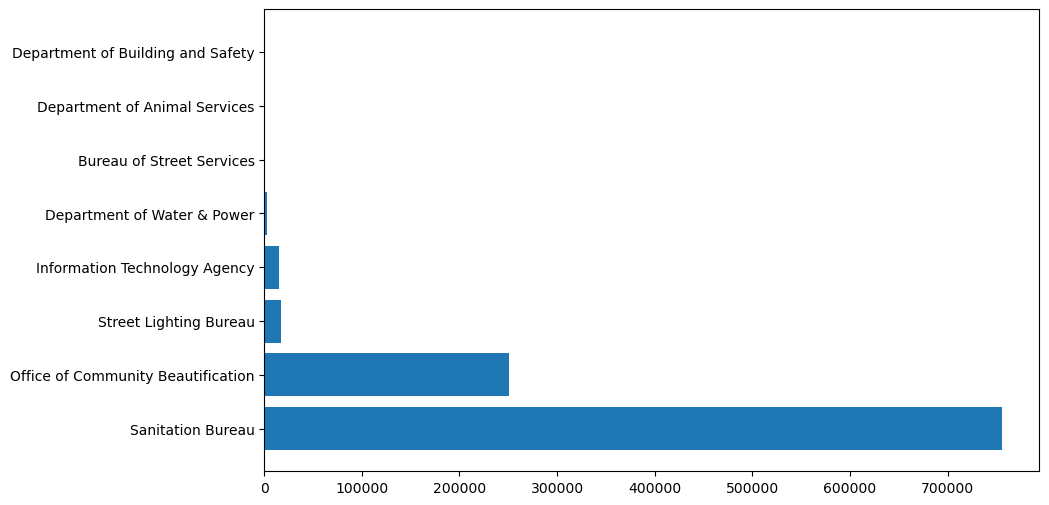

In [8]:
# Barh plot of agency and count of requests in dataset
plt.figure(figsize = (10,6))
plt.barh(df_agency['agencyName'], df_agency['request_ct'])

# Show graph
plt.show()

## How strong are the correlations between request type and agency?

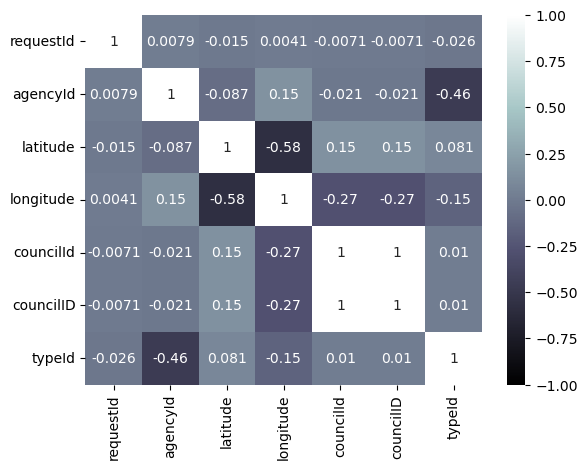

In [9]:
# heatmap of all quants in df
corr = df.corr()

sns.heatmap(corr,
           cmap = 'bone',
           annot = True,
           vmin = -1,
           vmax = 1);

In [10]:
# qualitative linkages between request type name and agency name
# create dummies for each request type and agency
type_agency = pd.get_dummies(df[['typeName', 'agencyName']])
type_agency.head()

,typeName_Animal Remains,typeName_Bulky Items,typeName_Electronic Waste,typeName_Feedback,typeName_Graffiti,typeName_Homeless Encampment,typeName_Illegal Dumping,typeName_Metal/Appliances,typeName_Multiple Streetlights,typeName_Other,typeName_Single Streetlight,typeName_Water Waste,agencyName_Bureau of Street Services,agencyName_Department of Animal Services,agencyName_Department of Building and Safety,agencyName_Department of Water & Power,agencyName_Information Technology Agency,agencyName_Office of Community Beautification,agencyName_Sanitation Bureau,agencyName_Street Lighting Bureau
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


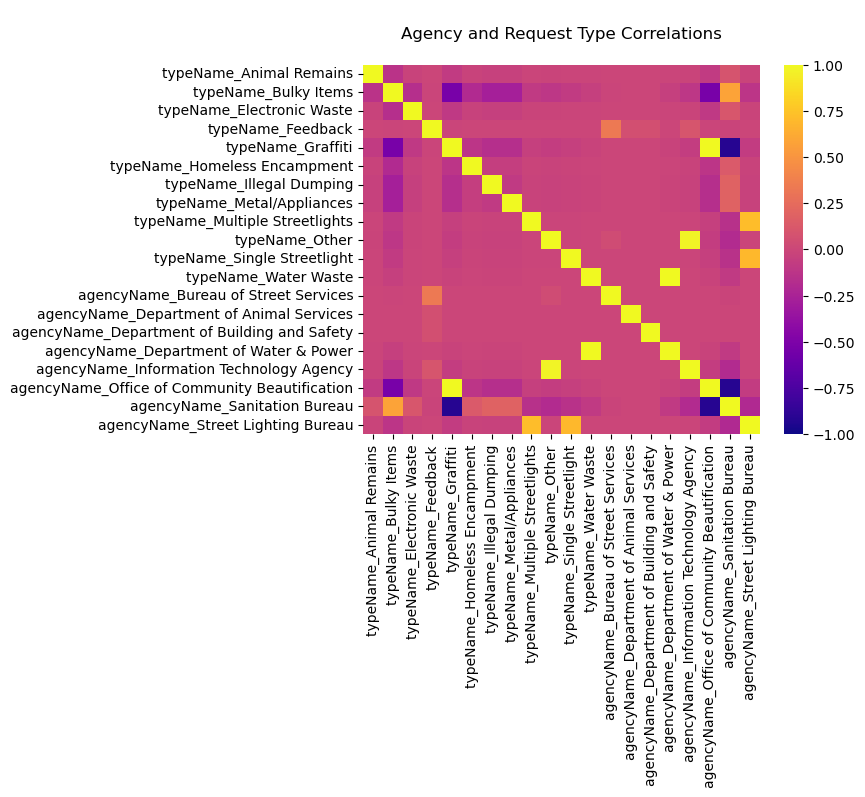

In [11]:
# heatmap the dummies
corr2 = type_agency.corr()

sns.heatmap(corr2,
           cmap = 'plasma',
           annot = False,
           vmin = -1,
           vmax = 1)
plt.title('\nAgency and Request Type Correlations\n')

plt.savefig('../images/type_agency_corr.jpg');

## Time series analysis of each agency and its requests, 4-week rolling average (mean), and percentage changes

In [12]:
# Created date to index
df.set_index('createdDate', inplace = True)

# Sort index for chronological order
df.sort_index(inplace = True)

In [55]:
# Resample for week
df_agency_ts = df.groupby(['agencyId', 'agencyName']).resample('W').size().reset_index(name = 'week_request_ct')

# format df_agency_ts for plots
df_agency_ts['createdDate'] = pd.to_datetime(df_agency_ts['createdDate'])

# Created date to index
df_agency_ts.set_index('createdDate', inplace = True)

# Sort index for chronological order
df_agency_ts.sort_index(inplace = True)

df_agency_ts.head(20)

,agencyId,agencyName,week_request_ct
createdDate,,,
2021-10-03,1,Street Lighting Bureau,107
2021-10-03,6,Department of Water & Power,19
2021-10-03,4,Office of Community Beautification,1479
2021-10-03,3,Sanitation Bureau,5494
2021-10-03,5,Information Technology Agency,312
2021-10-10,7,Bureau of Street Services,6
2021-10-10,4,Office of Community Beautification,6178
2021-10-10,6,Department of Water & Power,34
2021-10-10,1,Street Lighting Bureau,333


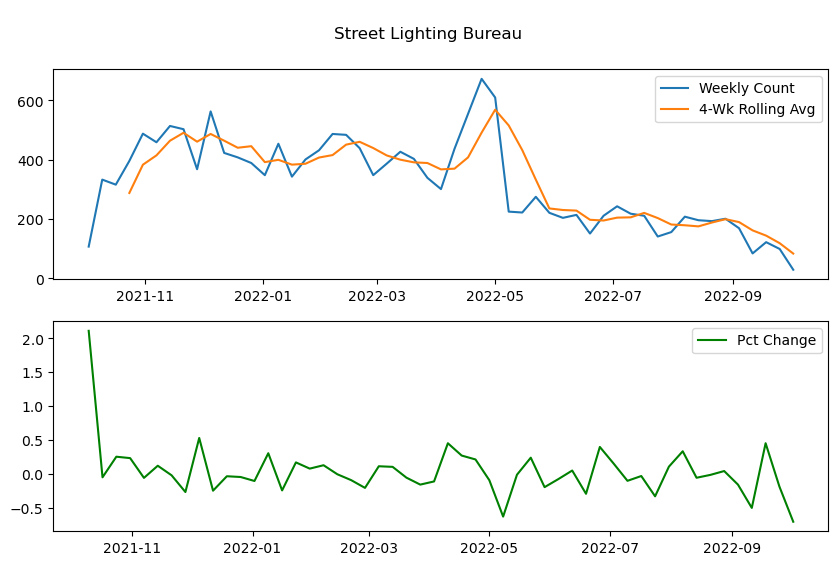

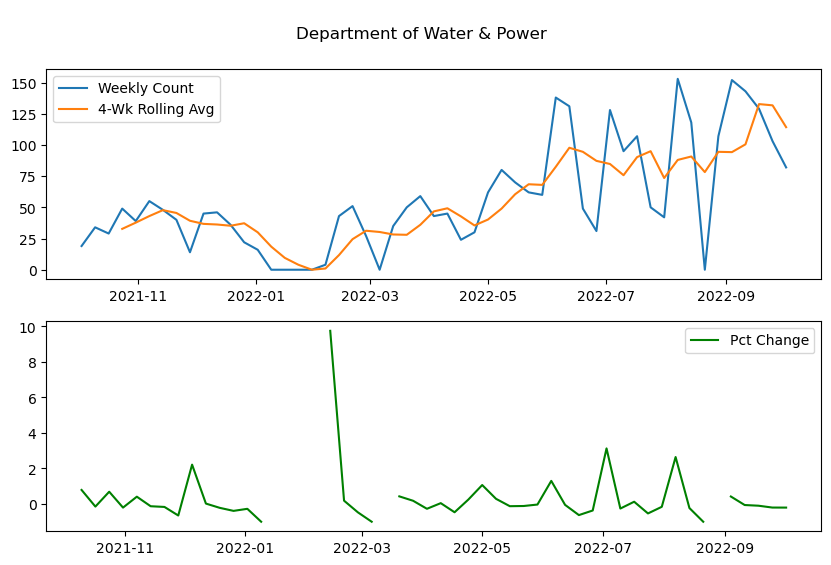

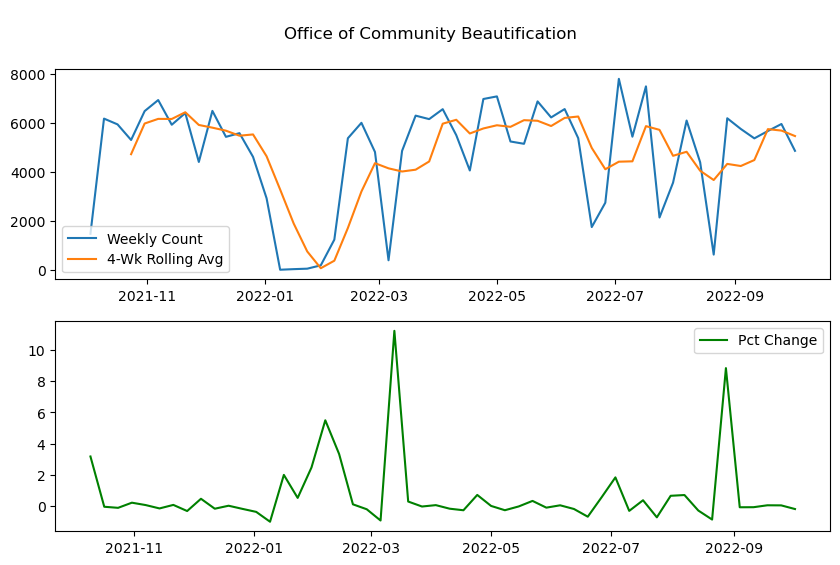

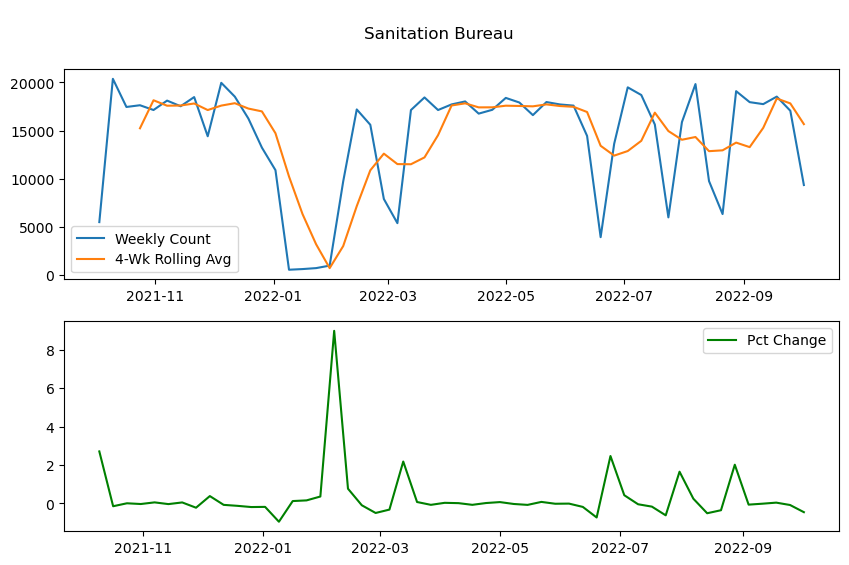

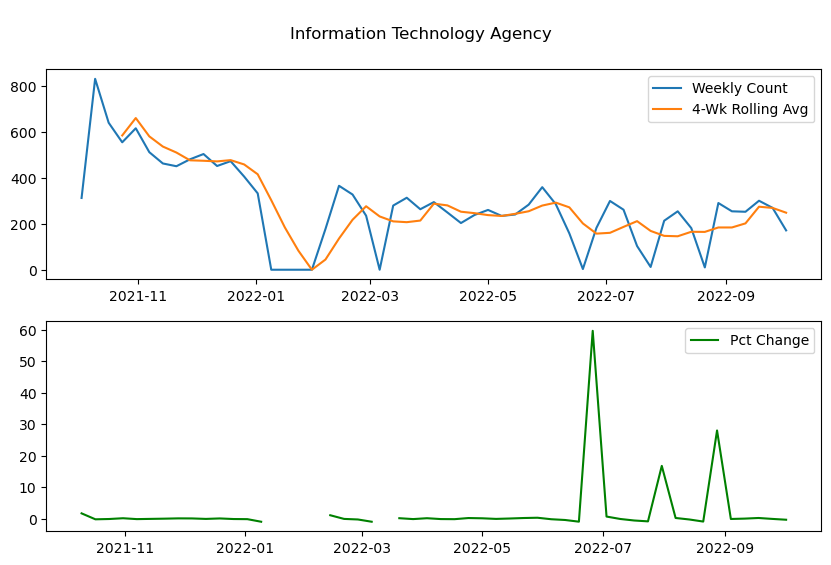

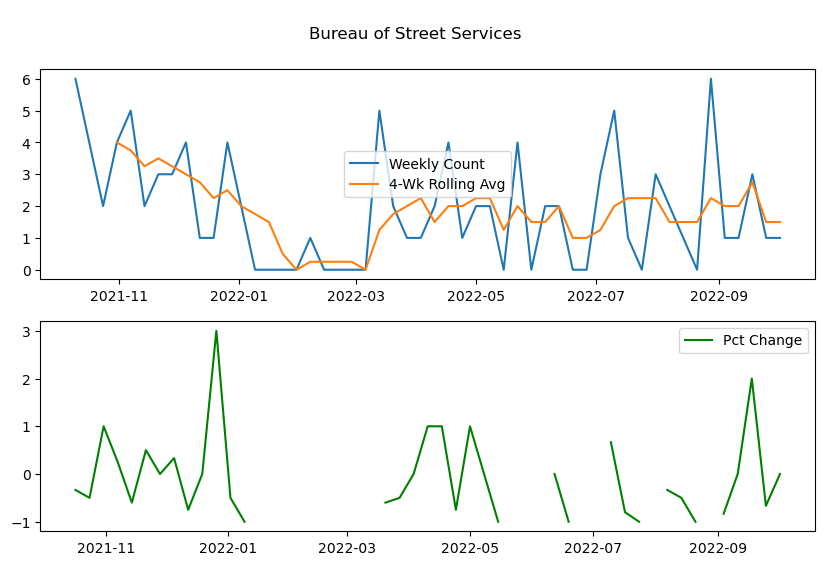

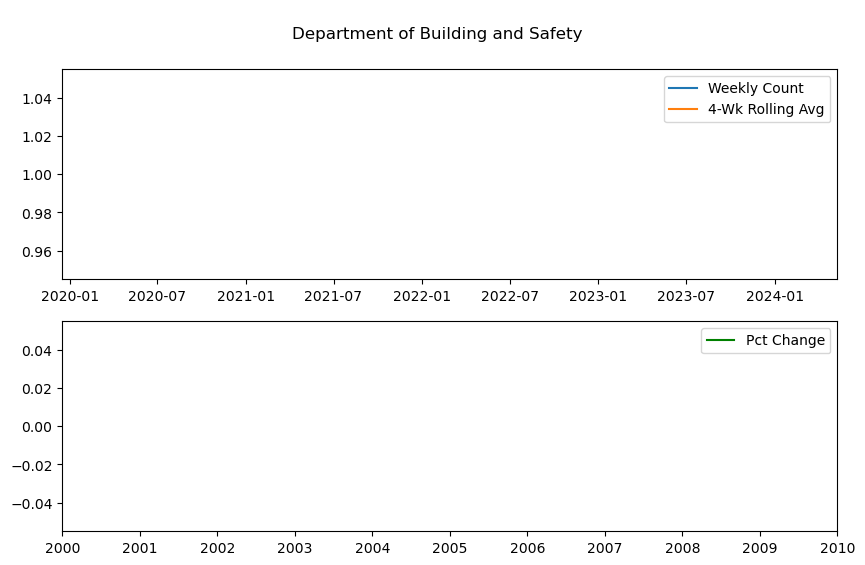

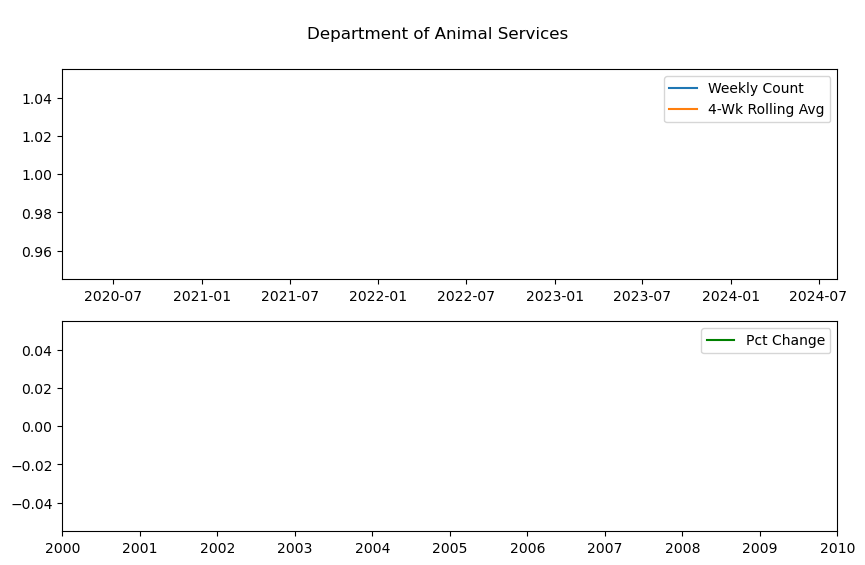

In [65]:
# loop through and plot request count and rolling 4 week average for each agency 
# dips in January for all, street lighting goes down, water & power goes up
# beautification and sanitation has dips, IT falls off and then has dips
# street services might have some seasonality

for agency in df_agency_ts['agencyName'].unique():
    temp_df = df_agency_ts[df_agency_ts['agencyName'] == agency]
    fig, axes = plt.subplots(nrows = 2, figsize = (10,6))
    fig.suptitle('\n' + agency + '\n')

    axes[0].plot(temp_df['week_request_ct'])
    axes[0].plot(temp_df['week_request_ct'].rolling(4).mean())
    axes[0].legend(['Weekly Count', '4-Wk Rolling Avg'])

    axes[1].plot(temp_df['week_request_ct'].pct_change(), c = 'g')
    axes[1].legend(['Pct Change'])

    plt.savefig('../images/' + agency + '_roll4.jpg');